In [1]:
import configs
import torch 
import pickle as pkl
import tiled_events as te
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import posteriors as pos
import seaborn as sns 
import numpy as np
import raw_events as rev
import os
import cr_sources as crs
import util
import pandas as pd
import plotting
from tqdm import tqdm
from scipy.stats import gaussian_kde

# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")
config_name = "full_priors_restrict_azimuth_uniform_test_limit_cal_no_shift_fmpe_all_train_data_posterior_ts_4gev_hawc"
config, out_dir, model, test_ds, qr, qr_data, filtered_manifest, unfiltered_manifest = util.load_config_data(
    config_name,
    results_dir="/home/export/ajshen/ada-sbi-cosmic-rays/results/",
    get_model=True,
    get_test_ds=True,
    get_qr_data=True,
    get_qr=True,
    manual_device=DEVICE
)
precomputed_weighters = [None, None, None]
with open(out_dir + "test_manifest.pkl", "rb") as f:
    test_manifest = pkl.load(f)
test_manifest["azimuth_pm90"] = (test_manifest["azimuth"] + np.pi/2) % np.pi - np.pi/2

2025-05-01 18:00:44.189918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 18:00:44.190059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 18:00:44.541032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 18:00:45.745367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 18:01:14.396036: W tensorflow/compiler/tf2

OVERWRITING DEFAULT DEVICE


Sparse Grid Features: 100%|██████████| 42270/42270 [00:21<00:00, 2001.18it/s]


Parameter Weighter set to -1


In [2]:
import diagnostics as diag
import importlib 
importlib.reload(diag)


joint_hpd_hits, joint_hpd_sizes, hpd_param_values, hpd_weights = diag.hpd_coverage_metrics(
    config,
    out_dir + "hpd_metrics.pkl",
    model,
    test_ds,
    config.coverage_calc_grid_num_points,
    config.confidence_levels[0]
)
joint_hpd_hits = np.array(joint_hpd_hits)
    
hpd_coverage_estimator, out_parameters, mean_proba, upper_proba, lower_proba = diag.estimate_coverage(
    config,
    out_dir + "hpd_coverage_estimator.pkl",
    config.coverage_calc_grid_num_points,
    joint_hpd_hits,
    hpd_param_values
)
    

joint_lf2i_hits, joint_lf2i_sizes, lf2i_param_values, lf2i_weights = diag.lf2i_coverage_metrics(
    config,
    out_dir + "lf2i_metrics.pkl",
    model,
    test_ds,
    config.coverage_calc_grid_num_points,
    qr
)
joint_lf2i_hits = np.array(joint_lf2i_hits)

lf2i_coverage_estimator, out_parameters, mean_proba, upper_proba, lower_proba = diag.estimate_coverage(
    config,
    out_dir + "lf2i_coverage_estimator.pkl",
    config.coverage_calc_grid_num_points,
    joint_lf2i_hits,
    lf2i_param_values
)

# Layout

Param Weight Bins: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
TBB Warning: The number of workers is currently limited to 1. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



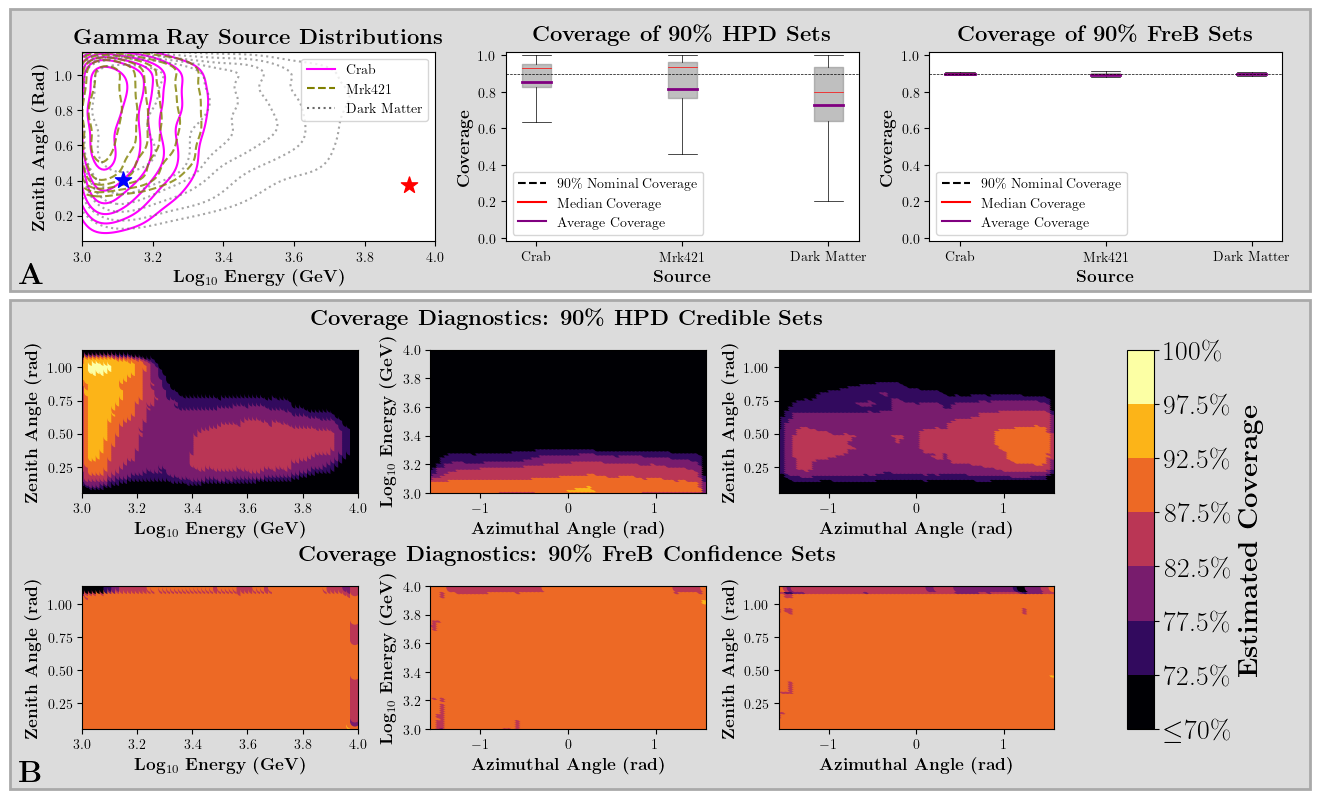

In [3]:
%matplotlib inline
import plotting
import importlib
importlib.reload(plotting)

# Original values from observer latitude -15
if config.use_posterior:
    # obs_id1 = 665
    # obs_id2 = 3045
    obs_id1 = 885
    obs_id2 = 26085
else:
    # obs_id1 = 8711
    # obs_id2 = 14850
    raise NotImplementedError()

fig = plotting.plot_paper_figure_1(
    config,
    test_ds,
    unfiltered_manifest,
    filtered_manifest,
    precomputed_weighters,
    hpd_coverage_estimator,
    hpd_param_values,
    joint_hpd_hits,
    lf2i_coverage_estimator,
    lf2i_param_values,
    joint_lf2i_hits,
    obs_id1,
    obs_id2,
    axis_font_size=12.5,
    title_font_size=16,
)
fig.savefig(out_dir + "fig1.png")

In [4]:
import nde_models

plot_data_sets = list()
plot_param_grid = pos.get_param_grid(
    config.eval_param_mins,
    config.eval_param_maxes,
    100_000
)
is_npse = None 
if type(model) is nde_models.WeightedFMPE:
    is_npse = False
    
if type(model) is nde_models.WeightedNPSE:
    is_npse = True
    
for obs_id in [obs_id1, obs_id2]:
    print(obs_id)
    hpd_set, _ = pos.get_hpd_set(
        model,
        plot_param_grid,
        0.9,
        test_ds[obs_id]['features'],
        config.train_param_mins,
        config.train_param_maxes,
        hpd_set_type="joint",
        is_npse=is_npse
    )

    waldo_set, _, grid_crits = pos.lf2i_confidence_set(
        qr,
        model,
        100_000,
        plot_param_grid,
        config.train_param_mins,
        config.train_param_maxes,
        test_ds[obs_id]['features'].to(DEVICE),
        is_npse,
        config.use_posterior
    )
    plot_data_sets.append((hpd_set, waldo_set))

885


Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


26085


Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


/home/export/ajshen/ada-sbi-cosmic-rays/lf2i_repo/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/ajshen/ada-sbi-cosmic-rays/lf2i_repo/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")


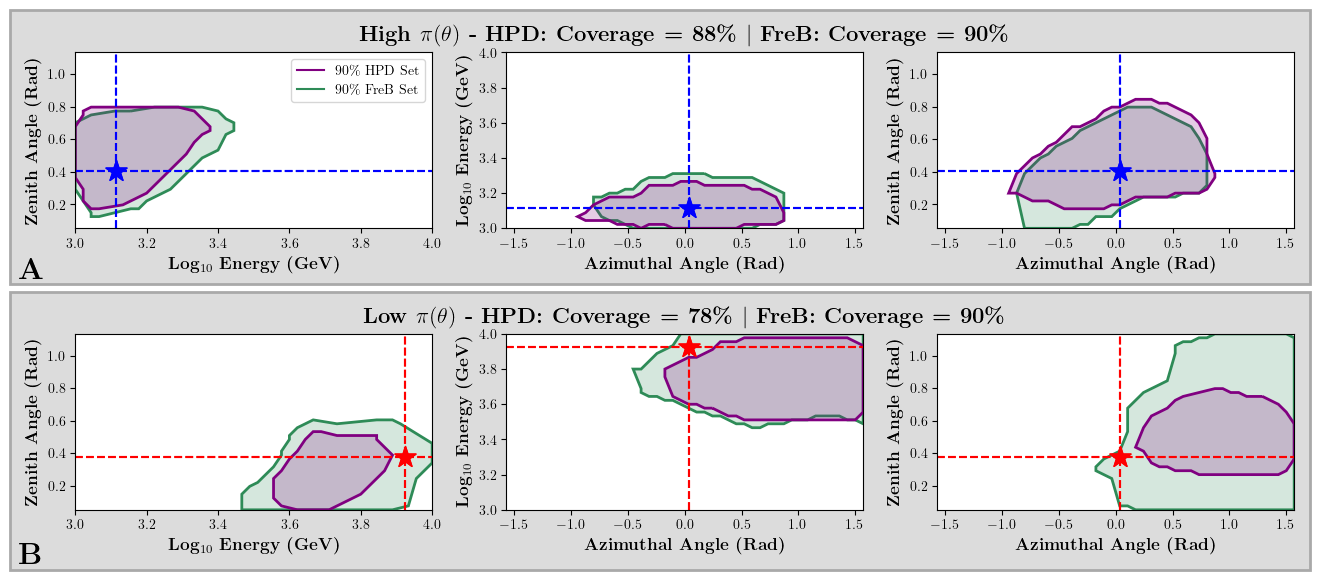

In [22]:
import plotting
import importlib
importlib.reload(plotting)

fig, axs = plotting.plot_paper_figure_2(
    config,
    (obs_id1, obs_id2),
    plot_data_sets,
    test_ds,
    hpd_coverage_estimator,
    lf2i_coverage_estimator
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.6)
fig.savefig(out_dir + "fig2")


# Supplementary Materials

In [6]:
import util
import importlib
importlib.reload(util)

config_name = "full_priors_restrict_azimuth_uniform_test_limit_cal_no_shift_fmpe_all_train_data_posterior_ts"
# config_name = "full_priors_restrict_azimuth_uniform_test_limit_cal_no_shift_corrected_code"
_, other_out_dir, _, big_test_ds, _, _, _, _ = util.load_config_data(
    config_name,
    results_dir="/home/export/ajshen/ada-sbi-cosmic-rays/results/",
    get_model=False,
    get_test_ds=True,
    get_qr_data=False,
    manual_device=DEVICE
)
with open(other_out_dir + "test_manifest.pkl", "rb") as f:
    big_test_manifest = pkl.load(f)
    
plot_id = big_test_manifest[big_test_manifest["log10_energy"] > 5.9].index[0]
big_test_ds.skip_scaling = True
plot_event = big_test_ds[plot_id]

FileNotFoundError: [Errno 2] No such file or directory: '/home/export/ajshen/ada-sbi-cosmic-rays/vsi_splits_flexible_priors_uniform_test/test.pkl'

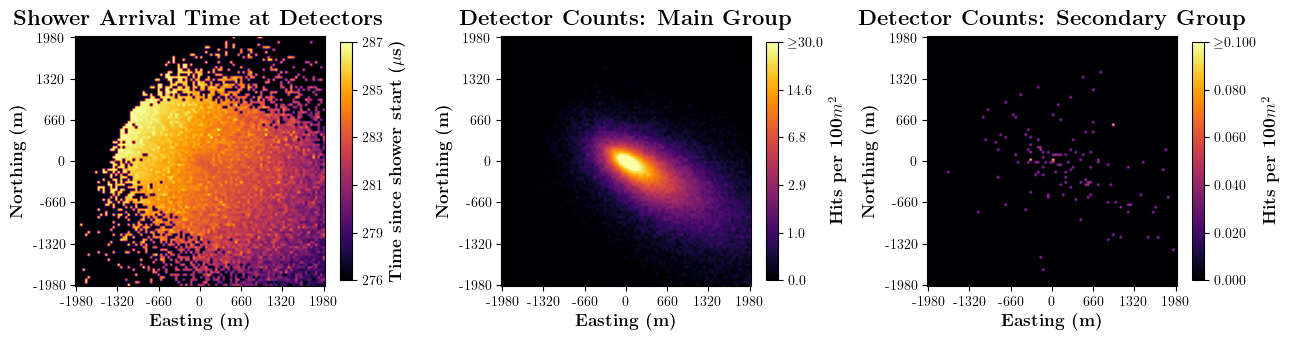

In [17]:
import plotting
import importlib
importlib.reload(plotting)

fig = plotting.plot_appendix_1(plot_event)
fig.savefig(out_dir + "appendix1.png")


In [19]:
del big_test_ds

Train: 1072821
Calibration: 98765
Evaluation: 42270


/home/export/ajshen/ada-sbi-cosmic-rays/vsi/src/vsi/cosmic_rays/plotting.py:998: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i, 1].set_title(r"\textbf{Histogram of Zenith", fontsize=title_font_size, pad=padding)


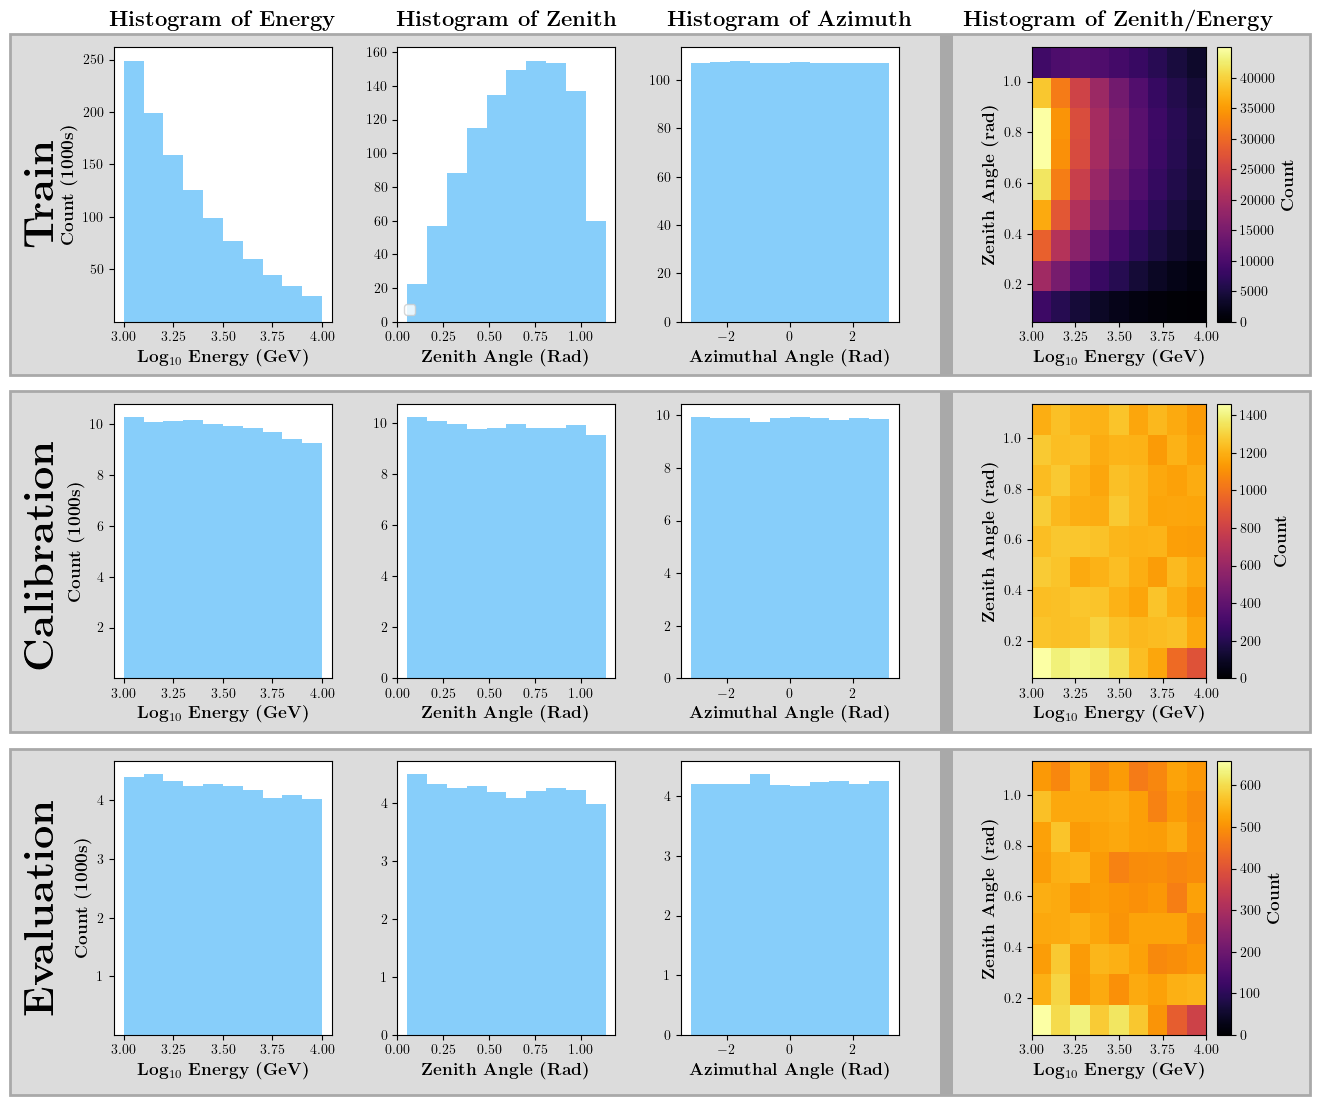

In [35]:
import importlib
importlib.reload(plotting)

fig = plotting.plot_appendix_2(
    config,
    out_dir
)
fig.subplots_adjust(hspace=0.3)
fig.savefig(out_dir + "appendix2.png")

In [26]:
import importlib
importlib.reload(plotting)
# precomputed_weighters = [None, None, None]

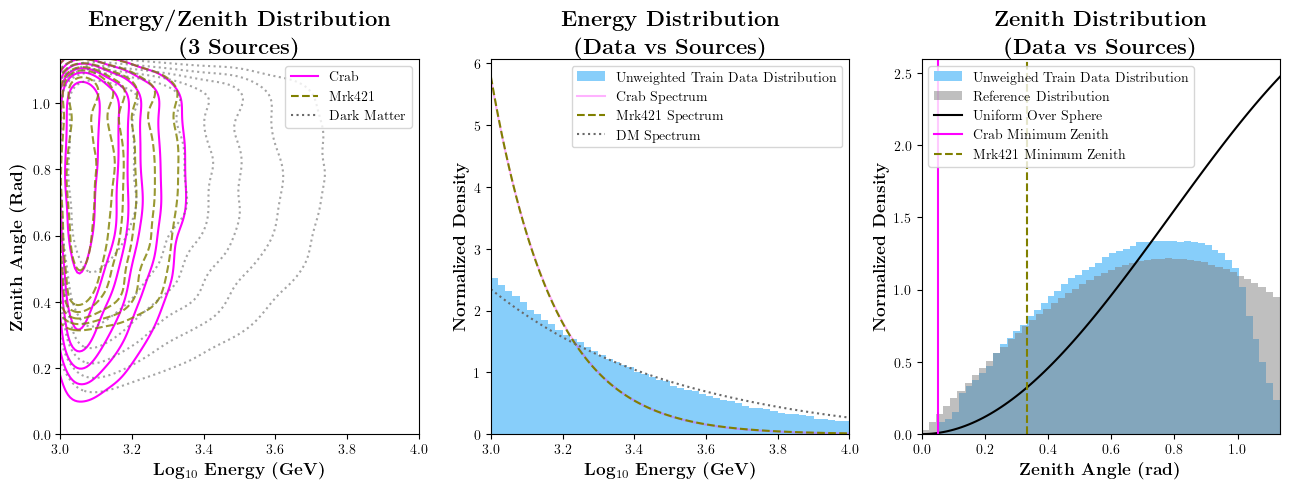

In [32]:
%matplotlib inline
import importlib
importlib.reload(plotting)

with open(out_dir + "train_manifest.pkl", "rb") as file:
    train_manifest_df = pkl.load(file)

fig = plotting.plot_appendix_3(
    config,
    unfiltered_manifest,
    filtered_manifest,
    train_manifest_df,
    precomputed_weighters
)
fig.savefig(out_dir + "appendix3.png")



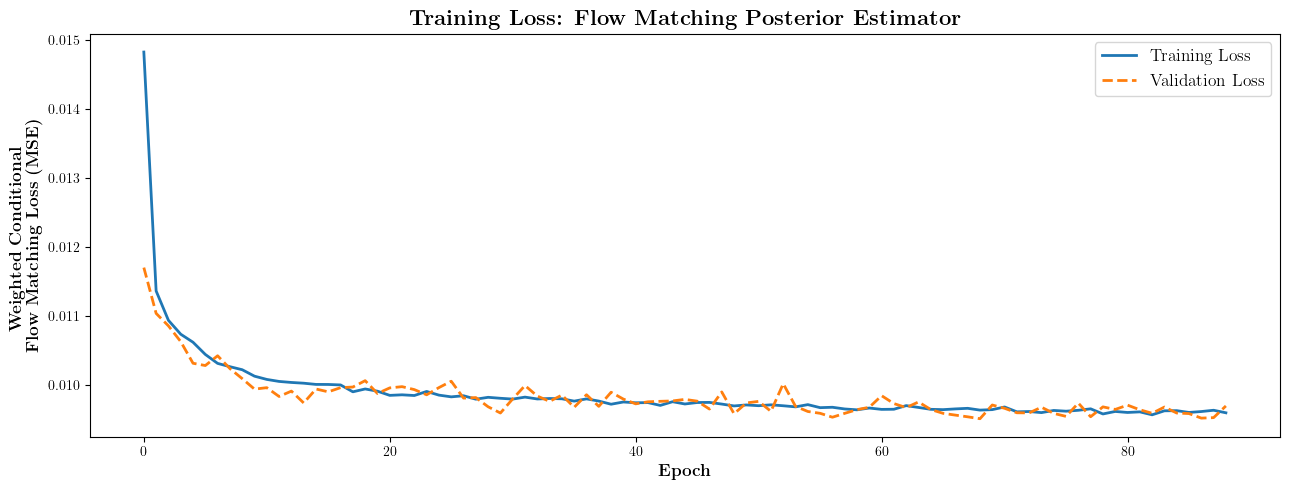

In [38]:
import importlib
importlib.reload(plotting)

fig = plotting.plot_appendix_4(out_dir)
fig.savefig(out_dir + "appendix4.png")

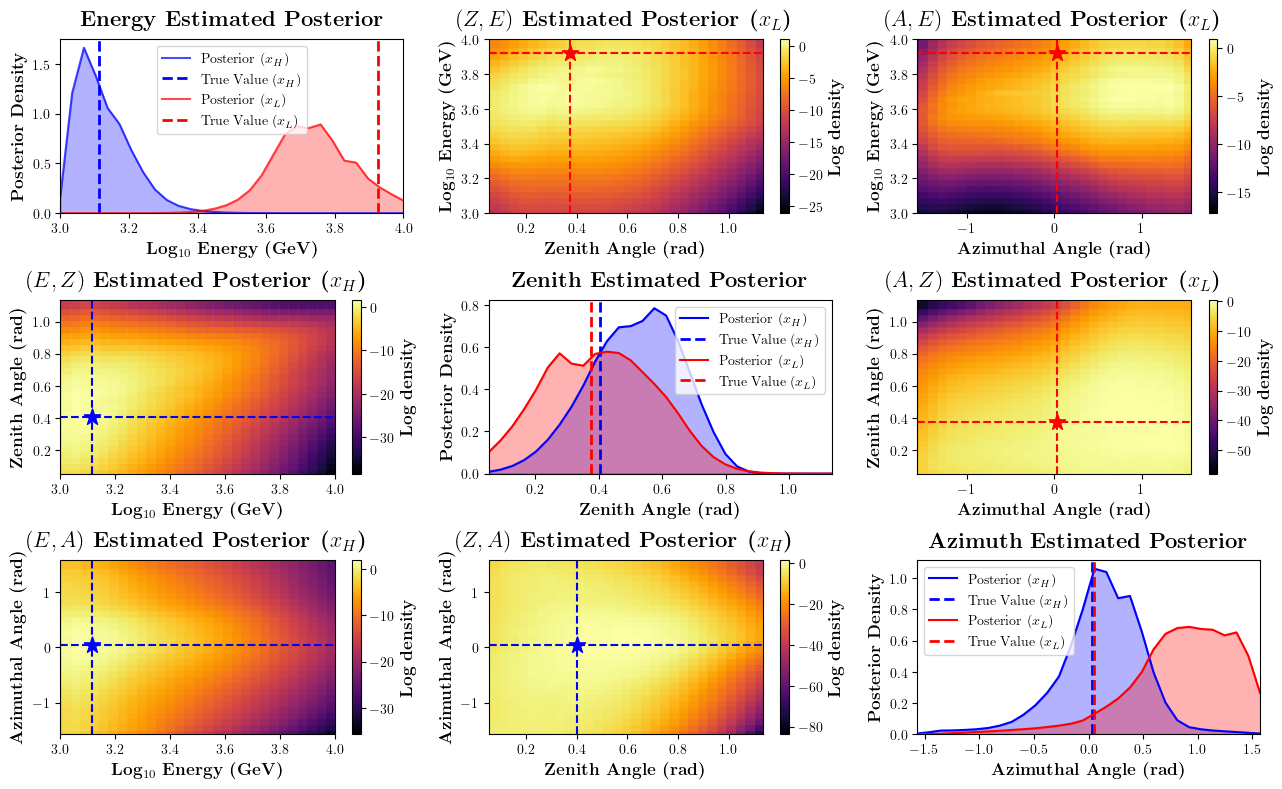

In [50]:
import importlib
importlib.reload(plotting)

fig = plotting.plot_appendix_5(
    config,
    model,
    DEVICE, 
    30,
    120,
    test_ds[obs_id1],
    test_ds[obs_id2]
)
fig.subplots_adjust(hspace=0.5)
fig.savefig(out_dir + "appendix5.png")

In [25]:
test_ds[obs_id1]['params']

tensor([3.1143, 0.4029, 0.0355])

/home/export/ajshen/ada-sbi-cosmic-rays/lf2i_repo/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/ajshen/ada-sbi-cosmic-rays/vsi/src/vsi/cosmic_rays/plotting.py:1551: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.tight_layout()


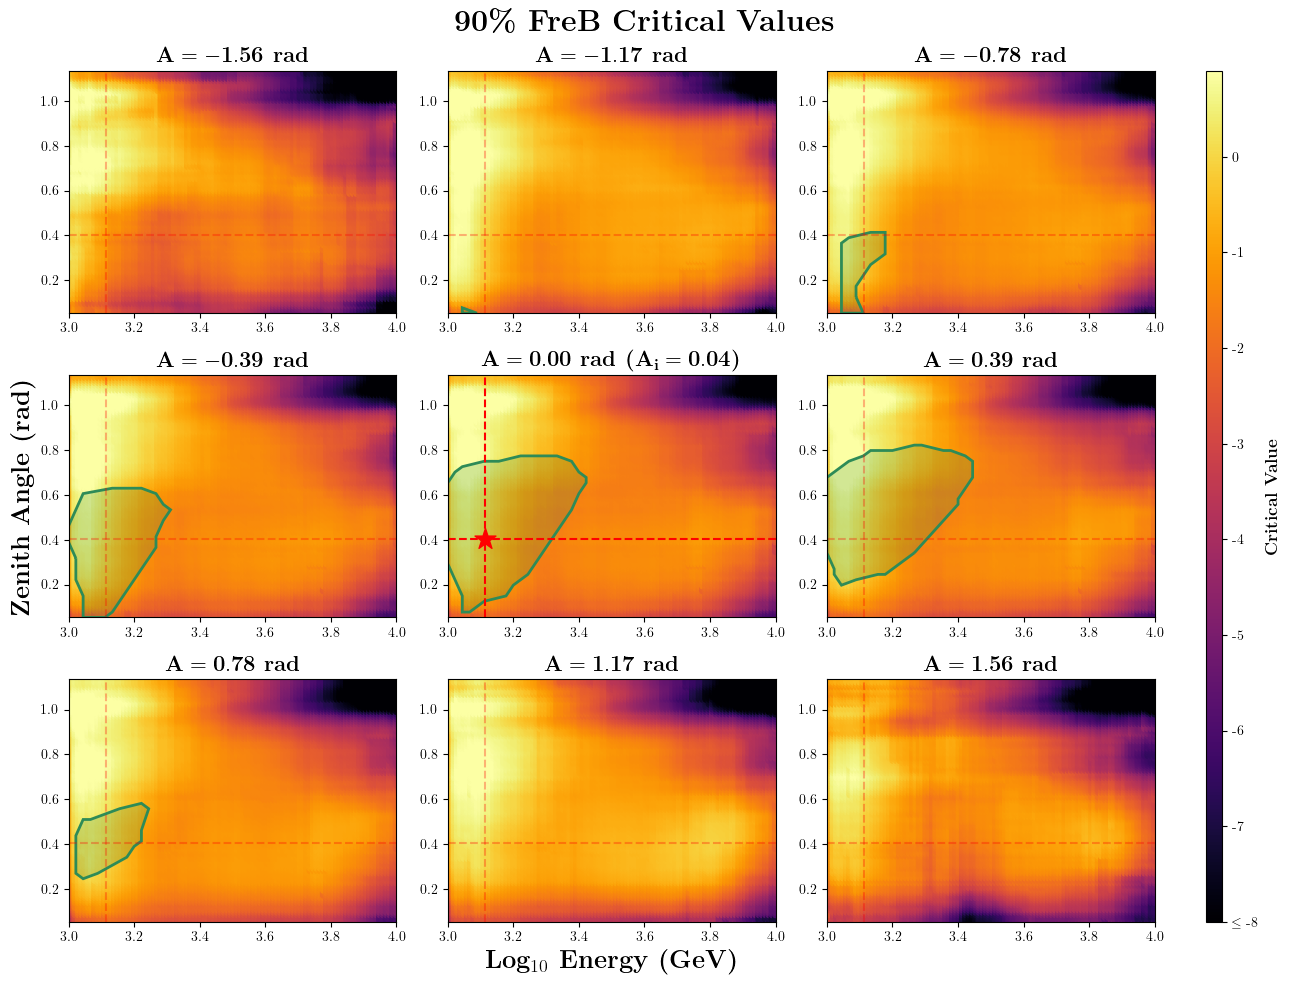

In [43]:
import importlib
importlib.reload(plotting)

fig = plotting.plot_appendix_6(
    config,
    qr,
    test_ds[obs_id1],
    plot_data_sets[0][1]
)
fig.savefig(out_dir + "appendix6.png")

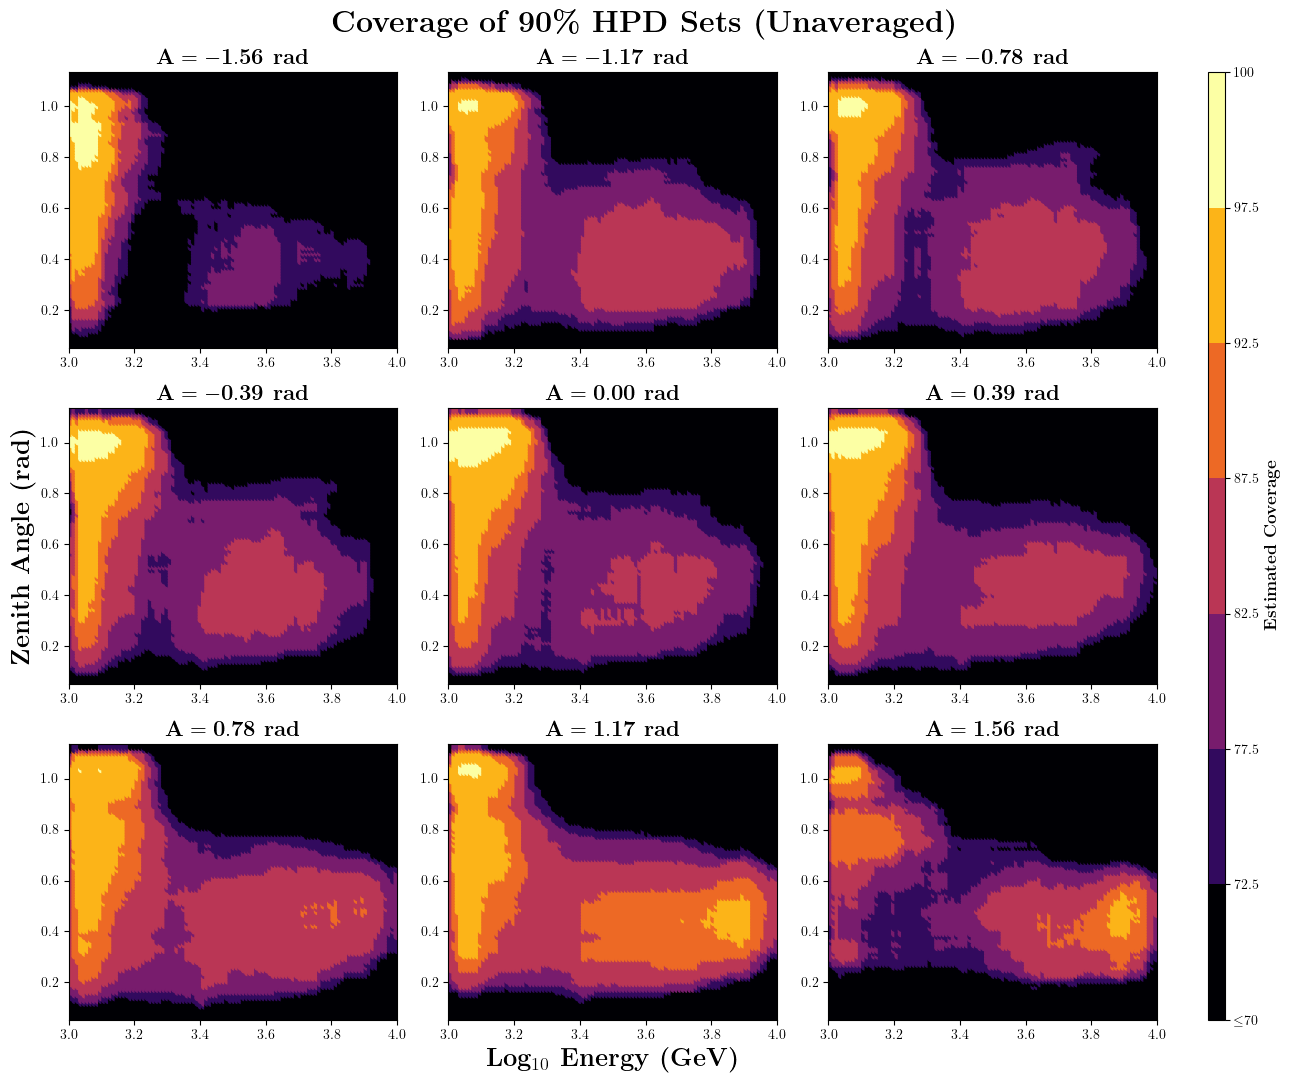

In [45]:
import importlib 
importlib.reload(plotting)

fig = plotting.plot_appendix_7(
    config,
    hpd_coverage_estimator,
)
fig.savefig(out_dir + "appendix7.png")

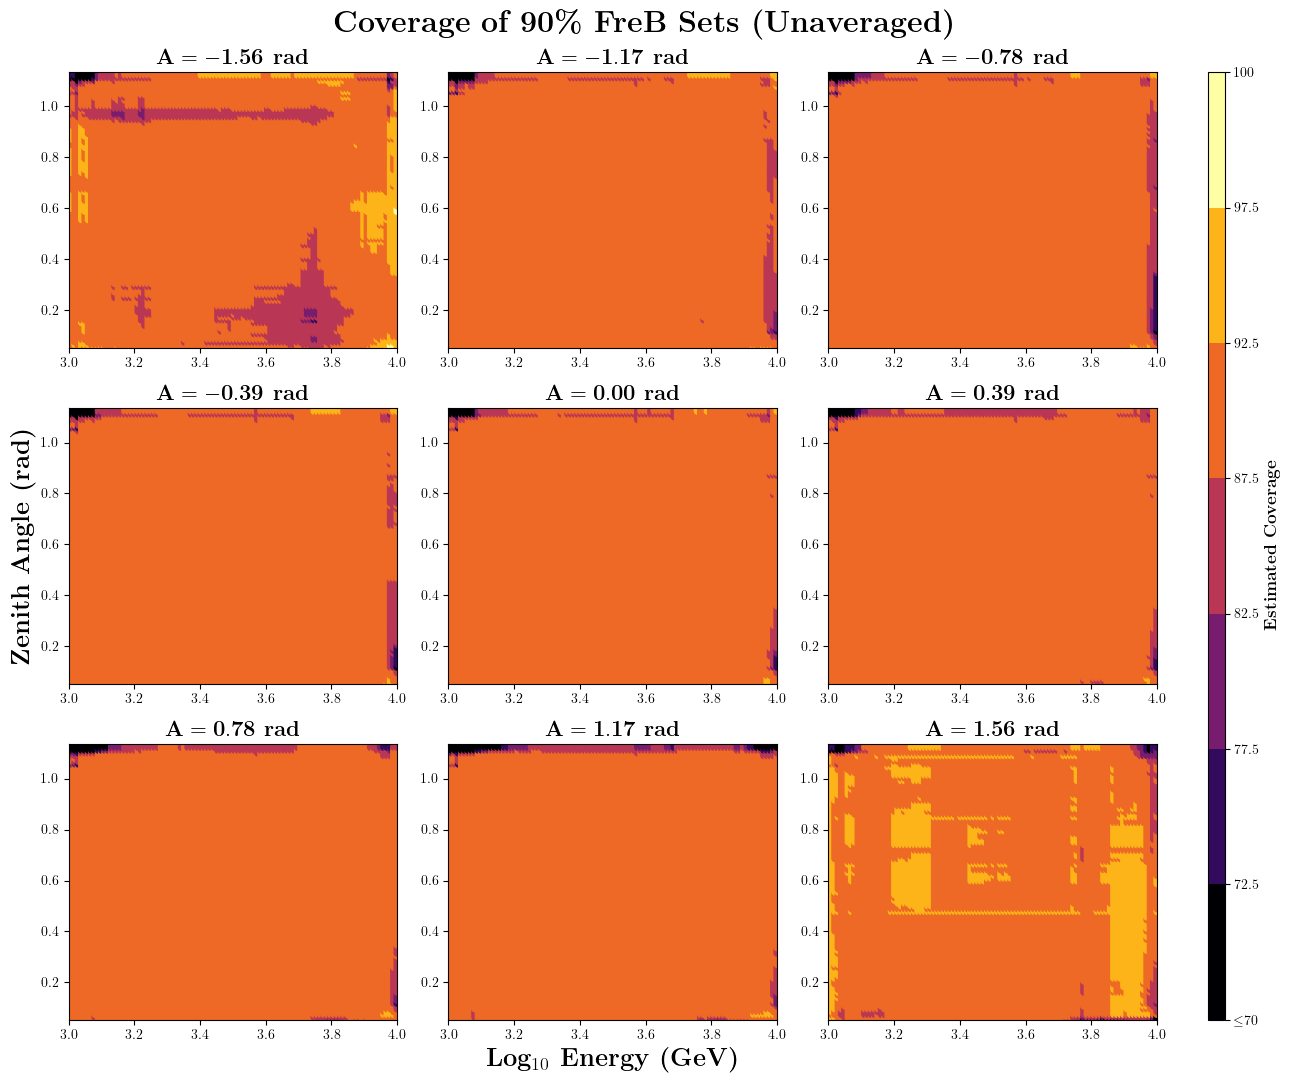

In [48]:
import importlib 
importlib.reload(plotting)

fig = plotting.plot_appendix_8(
    config,
    lf2i_coverage_estimator,
)
fig.savefig(out_dir + "appendix8.png")

In [5]:
test_ds.skip_scaling = True
for plot_event in test_ds:
    if plot_event is not None and plot_event['params'][0] > 3.9:
        print(plot_event['params'])
        break
    
test_ds.skip_scaling = False

tensor([ 3.9936,  0.8446, -0.5326])


/home/export/ajshen/ada-sbi-cosmic-rays/lf2i_repo/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")


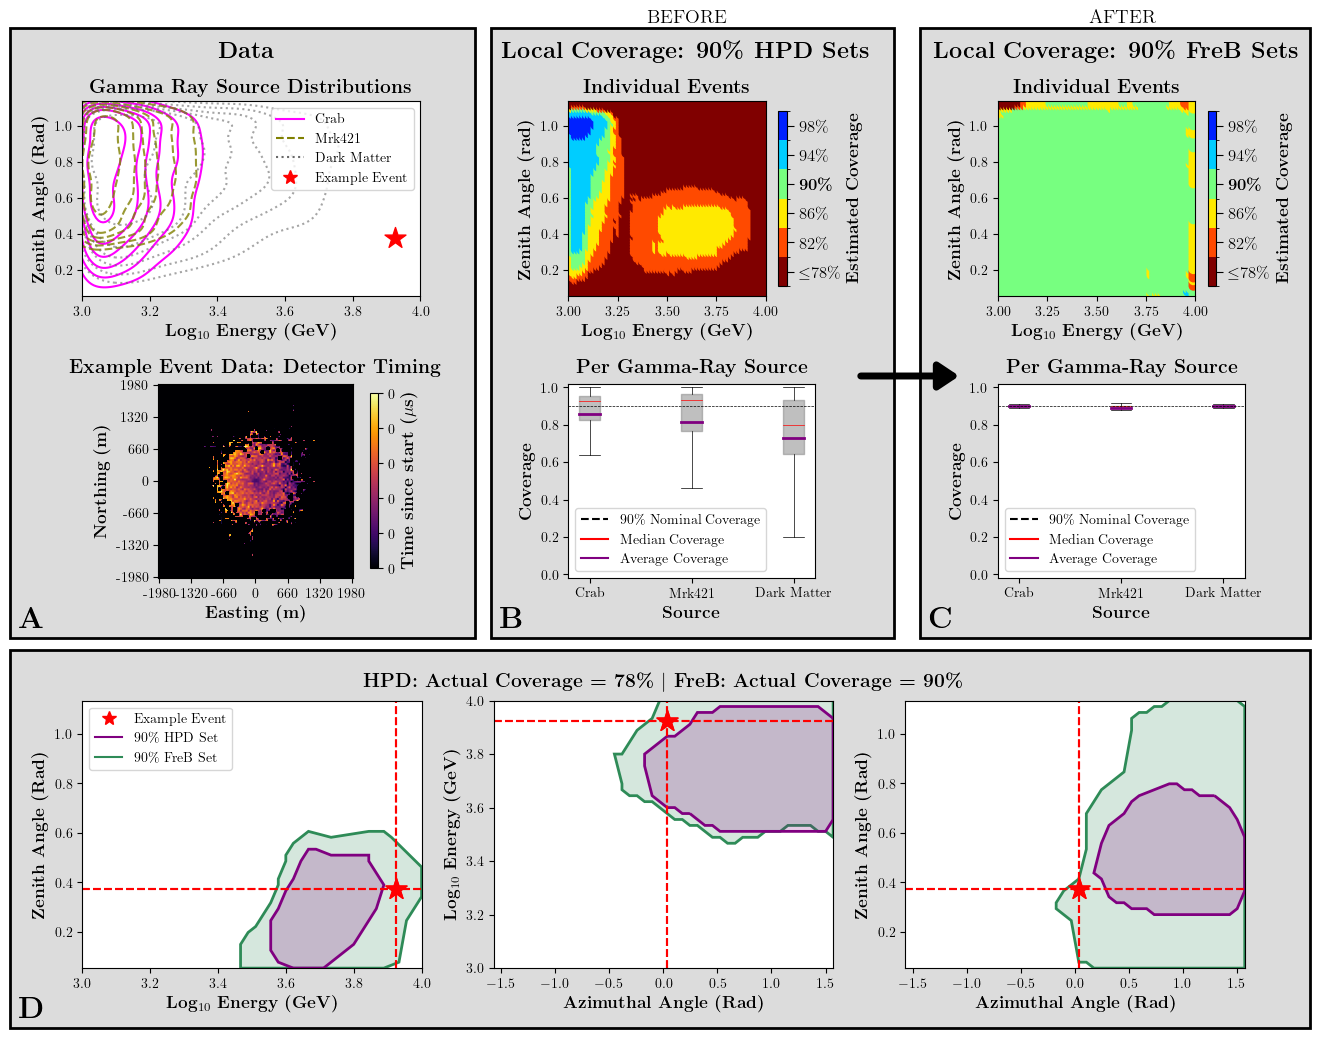

In [6]:
import plotting
import importlib
importlib.reload(plotting)

fig = plotting.plot_new_fig_1(
    config,
    unfiltered_manifest,
    filtered_manifest,
    precomputed_weighters,
    test_ds[obs_id2],
    hpd_coverage_estimator,
    hpd_param_values,
    joint_hpd_hits,
    lf2i_coverage_estimator,
    lf2i_param_values,
    joint_lf2i_hits,
    test_ds[obs_id2],
    plot_data_sets[1],
    test_ds[obs_id1],
    plot_data_sets[0],
    test_layout_only=False,
    pickled_objects_file="plot_objects.pkl",
    overwrite_pickle=False
)
fig.tight_layout()
arrow_height = 0.662
arrow_start = 0.66
plt.annotate(
    '', xy=(arrow_start + 0.08, arrow_height), xytext=(arrow_start, arrow_height),
    xycoords='figure fraction',
    textcoords='figure fraction',
    arrowprops=dict(
        arrowstyle='-|>,head_width=0.8,head_length=1.2', 
        color='black', 
        lw=5
    )
)
# fig.text(0.622, arrow_height+0.018, "BEFORE", fontsize=12)
# fig.text(0.705, arrow_height+0.018, "AFTER", fontsize=12)
fig.text(0.49, 1.005, "BEFORE", fontsize=14)
fig.text(0.83, 1.005, "AFTER", fontsize=14)
fig.savefig(out_dir + "new_fig1.pdf", bbox_inches='tight')